In [1]:

import sys
sys.path.append('../codes')
import torch
from torch import nn
import numpy as np
import pandas as pd
import networks
import utils
import config
import loss
import trainer
import evaluator
import plots
from scipy.stats import spearmanr
from captum.attr import DeepLift
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
color_pallete = tuple(sns.color_palette("husl",2))
colors = []
color = [color_pallete[0],] * 296
colors += color
color = [color_pallete[1],] * 54
colors += color
# for color in color_pallete:
#     color = [color,] * 9
#     colors += color

In [3]:
class final_net(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(final_net, self).__init__()
        
        self.representation = None
        
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.25)
        self.softmax1 = nn.Softmax(dim=1)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.25)
        self.softmax2 = nn.Softmax(dim=1)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.25)
        self.softmax3 = nn.Softmax(dim=1)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
#         self.relu4 = nn.ReLU()
        
#         self.fc5 = nn.Linear(128, 1)

    def forward(self, x):
        
        out = self.fc1(x)
        out = self.relu1(out)
        # out = self.drop1(out)
        # x = self.softmax1(out)
        # out = out * x
        
        out = self.fc2(out)
        out = self.relu2(out)
        # out = self.drop2(out)
        # out = self.drop2(out)
        # x = self.softmax2(out)
        # out = x * out
        
        out = self.fc3(out)
        out = self.relu3(out)
        # out = self.drop3(out)
        # out = self.drop3(out)
        # x = self.softmax3(out)
        # out = out * x
        
        # out = self.fc4(out)
        # out = self.relu4(out)
        
        out = self.fc4(out)    
        
        return out
        



In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


## Unique Line

In [5]:
versions = ['v1', 'v2', 'v3', 'v4', 'v5']

avg_attributions =np.zeros((350,))
for version in versions:
    test_representation = '../processed_data/test_rep_learned_' + version + '.pkl'
    test_file = '../processed_data/test_geno_with_8_m_avg_all_data_{}.pkl'.format(version)
    model_path = '../outputs/fc_model_final_version_{}.pt'.format(version)
    test_loader = utils.create_dataloader_for_rep_learned_data(test_representation, test_file, 
                                                        is_training=False)
    rep_model = final_net(num_features = test_loader.dataset.data.shape[1], hidden_dim=233)
    rep_model.load_state_dict(torch.load(model_path))
    rep_model.to(device=device)                                                    
    
    data = test_loader.dataset.data
    data = torch.from_numpy(data)
    data = data.float()
    data = data.to(device=device)
    
    baseline = torch.zeros(data.shape)
    baseline = baseline.to(device=device)
    
    dl = DeepLift(rep_model)
    
    attributions, delta = dl.attribute(data, baseline, target=0, return_convergence_delta=True)
    attributions_sum = attributions.cpu().detach().numpy().sum(0)
    attributions_norm_sum = attributions_sum / np.linalg.norm(attributions_sum, ord=1)
    
    
    avg_attributions += attributions_norm_sum
    
    
    

/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [6]:
avg_attributions = avg_attributions/len(versions)


In [7]:
# avg_attributions = avg_attributions.sum(0)
# ticks = ['Precipitation', 'Humidity max', 'Humidity min', 'Radiation', 'Temp max', 'Temp min', 'Vap. pressure', 'Wind 2m', 'Wind 5m']

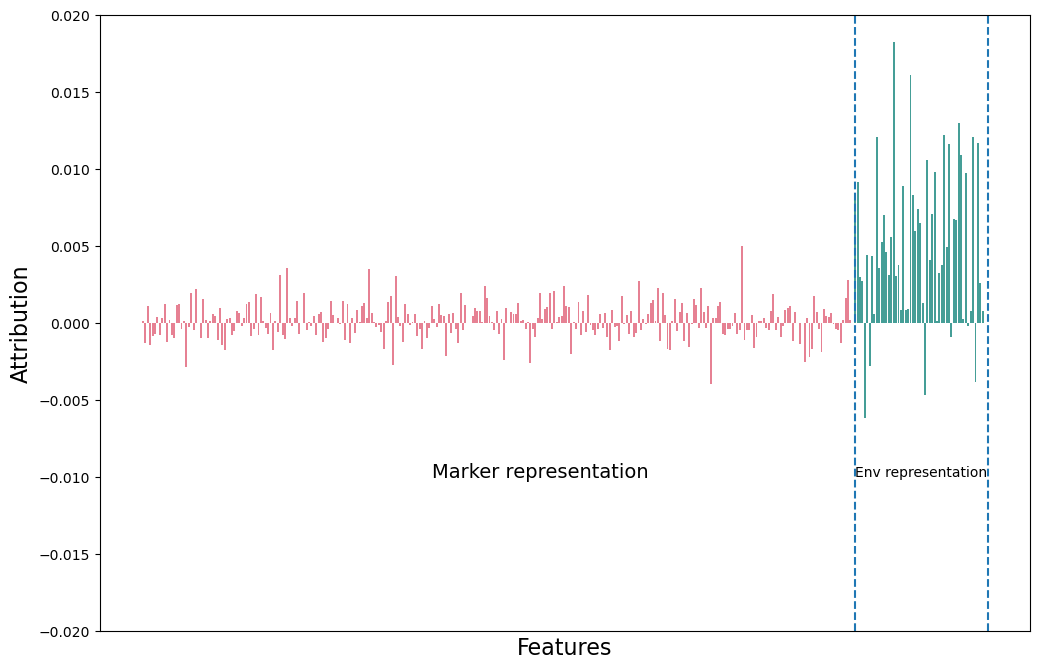

In [8]:

plt.figure(figsize=(12,8))
ax=sns.barplot(x=np.arange(avg_attributions.shape[0]), y=avg_attributions, palette=colors)
ax.set_ylabel('Attribution', fontsize=16)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylim((-0.02,0.02))
ax.set_xticks([])
plt.axvline(x=296, linestyle='--')
plt.axvline(x=351, linestyle='--')

plt.text(296, -0.010, 'Env representation')
plt.text(120, -0.010, 'Marker representation', fontsize=14)
fig = ax.get_figure()
fig.savefig('../figures/feature_importance_rep_learning_unique_line.jpeg', dpi=600, bbox_inches='tight')

## Unique Env

In [9]:
versions = ['v1', 'v2', 'v3', 'v4', 'v5']

avg_attributions =np.zeros((350,))
for version in versions:
    test_representation = '../processed_data/test_unique_env_rep_learned_' + version + '.pkl'
    test_file = '../processed_data/test_geno_unique_env_with_8_m_avg_all_data_{}.pkl'.format(version)
    model_path = '../outputs/fc_model_final_version_{}.pt'.format(version)
    test_loader = utils.create_dataloader_for_rep_learned_data(test_representation, test_file, 
                                                        is_training=False)
    rep_model = final_net(num_features = test_loader.dataset.data.shape[1], hidden_dim=233)
    rep_model.load_state_dict(torch.load(model_path))
    rep_model.to(device=device)                                                    
    
    data = test_loader.dataset.data
    data = torch.from_numpy(data)
    data = data.float()
    data = data.to(device=device)
    
    baseline = torch.zeros(data.shape)
    baseline = baseline.to(device=device)
    
    dl = DeepLift(rep_model)
    
    attributions, delta = dl.attribute(data, baseline, target=0, return_convergence_delta=True)
    attributions_sum = attributions.cpu().detach().numpy().sum(0)
    attributions_norm_sum = attributions_sum / np.linalg.norm(attributions_sum, ord=1)
    
    
    avg_attributions += attributions_norm_sum
    
    
    

/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [10]:
avg_attributions = avg_attributions/len(versions)


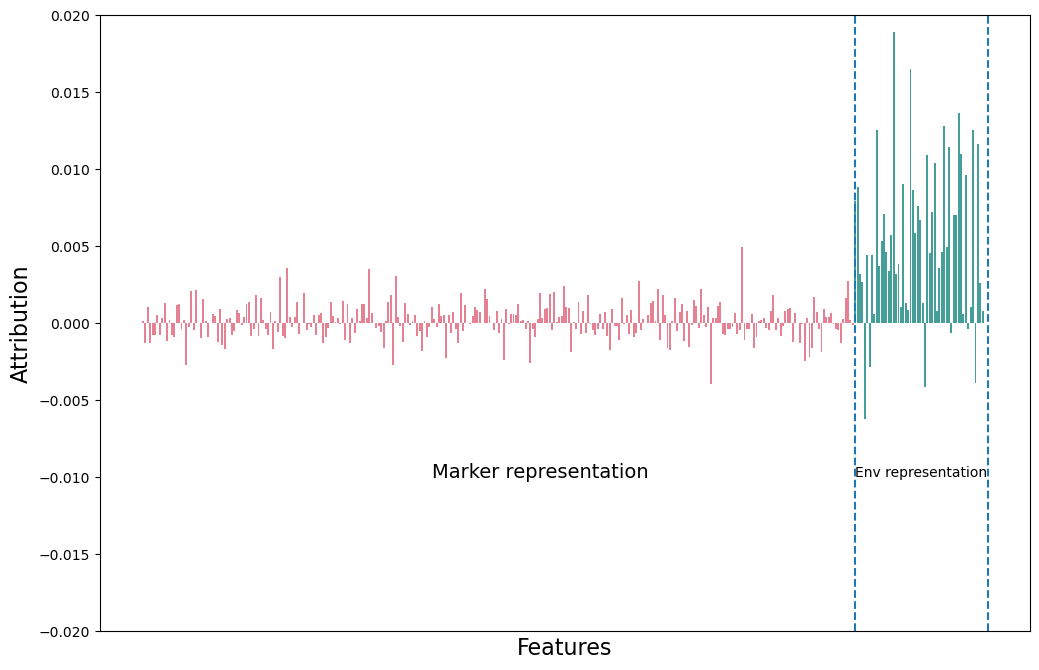

In [11]:

plt.figure(figsize=(12,8))
ax=sns.barplot(x=np.arange(avg_attributions.shape[0]), y=avg_attributions, palette=colors)
ax.set_ylabel('Attribution', fontsize=16)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylim((-0.02,0.02))
ax.set_xticks([])
plt.axvline(x=296, linestyle='--')
plt.axvline(x=351, linestyle='--')

plt.text(296, -0.010, 'Env representation')
plt.text(120, -0.010, 'Marker representation', fontsize=14)
fig = ax.get_figure()
fig.savefig('../figures/feature_importance_rep_learning_unique_env.jpeg', dpi=600, bbox_inches='tight')